In [88]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

* Read csv, remove puctuation, stopwords and apply stemming, replace keywords with 'NULL'

In [89]:
tweets = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
tweets['keyword'] = tweets['keyword'].fillna('NULL')
test['keyword'] = test['keyword'].fillna('NULL')

In [90]:
duplicates = tweets.duplicated(subset = 'text', keep = False)
duplicates.value_counts()

False    7434
True      179
dtype: int64

In [91]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7434 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


In [92]:
tweets['keyword'] = tweets.keyword.str.replace('%20',' ')

In [93]:
import string

tweets['text'] = tweets['text'].apply(lambda x: x.translate({ord(i): ' ' for i in string.punctuation}))
tweets.head()

,id,keyword,location,text,target
0,1,NULL,NaN,Our Deeds are the Reason of this earthquake M...,1
1,4,NULL,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NULL,NaN,All residents asked to shelter in place are ...,1
3,6,NULL,NaN,13 000 people receive wildfires evacuation or...,1
4,7,NULL,NaN,Just got sent this photo from Ruby Alaska as ...,1


In [94]:
tweets['text'] = tweets['text'].apply(lambda x: x.lower())

In [95]:
import io
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matiascano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
def remove_stopword(text):
    new_text = []
    for e in text:
        if e not in stopwords and e.isalpha():
            new_text.append(e)
    text = new_text
    return " ".join(new_text)

In [97]:
tweets['text'] = tweets['text'].str.split()
tweets['text'] = tweets['text'].apply(remove_stopword)
tweets.head()

,id,keyword,location,text,target
0,1,NULL,NaN,deeds reason earthquake may allah forgive us,1
1,4,NULL,NaN,forest fire near la ronge sask canada,1
2,5,NULL,NaN,residents asked shelter place notified officer...,1
3,6,NULL,NaN,people receive wildfires evacuation orders cal...,1
4,7,NULL,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [98]:
stemmer = SnowballStemmer('english')

In [99]:
def stemm(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [100]:
tweets['text'] = tweets['text'].apply(stemm)
tweets.head()

,id,keyword,location,text,target
0,1,NULL,NaN,deed reason earthquak may allah forgiv us,1
1,4,NULL,NaN,forest fire near la rong sask canada,1
2,5,NULL,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NULL,NaN,peopl receiv wildfir evacu order california,1
4,7,NULL,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


In [101]:
tweets.reset_index(drop=True, inplace=True)

In [102]:
tweets.head()

,id,keyword,location,text,target
0,1,NULL,NaN,deed reason earthquak may allah forgiv us,1
1,4,NULL,NaN,forest fire near la rong sask canada,1
2,5,NULL,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NULL,NaN,peopl receiv wildfir evacu order california,1
4,7,NULL,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


### Clustering graphic

* SVD

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(tweets['text'])

In [104]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
svd.fit(x_train_tfidf)
svd_result = svd.transform(x_train_tfidf)

In [105]:
to_plot = pd.DataFrame({'x': svd_result[:, 0], 'y': svd_result[:, 1], 'target': tweets['target']})

In [106]:
to_plot.reset_index(inplace=True, drop=True)

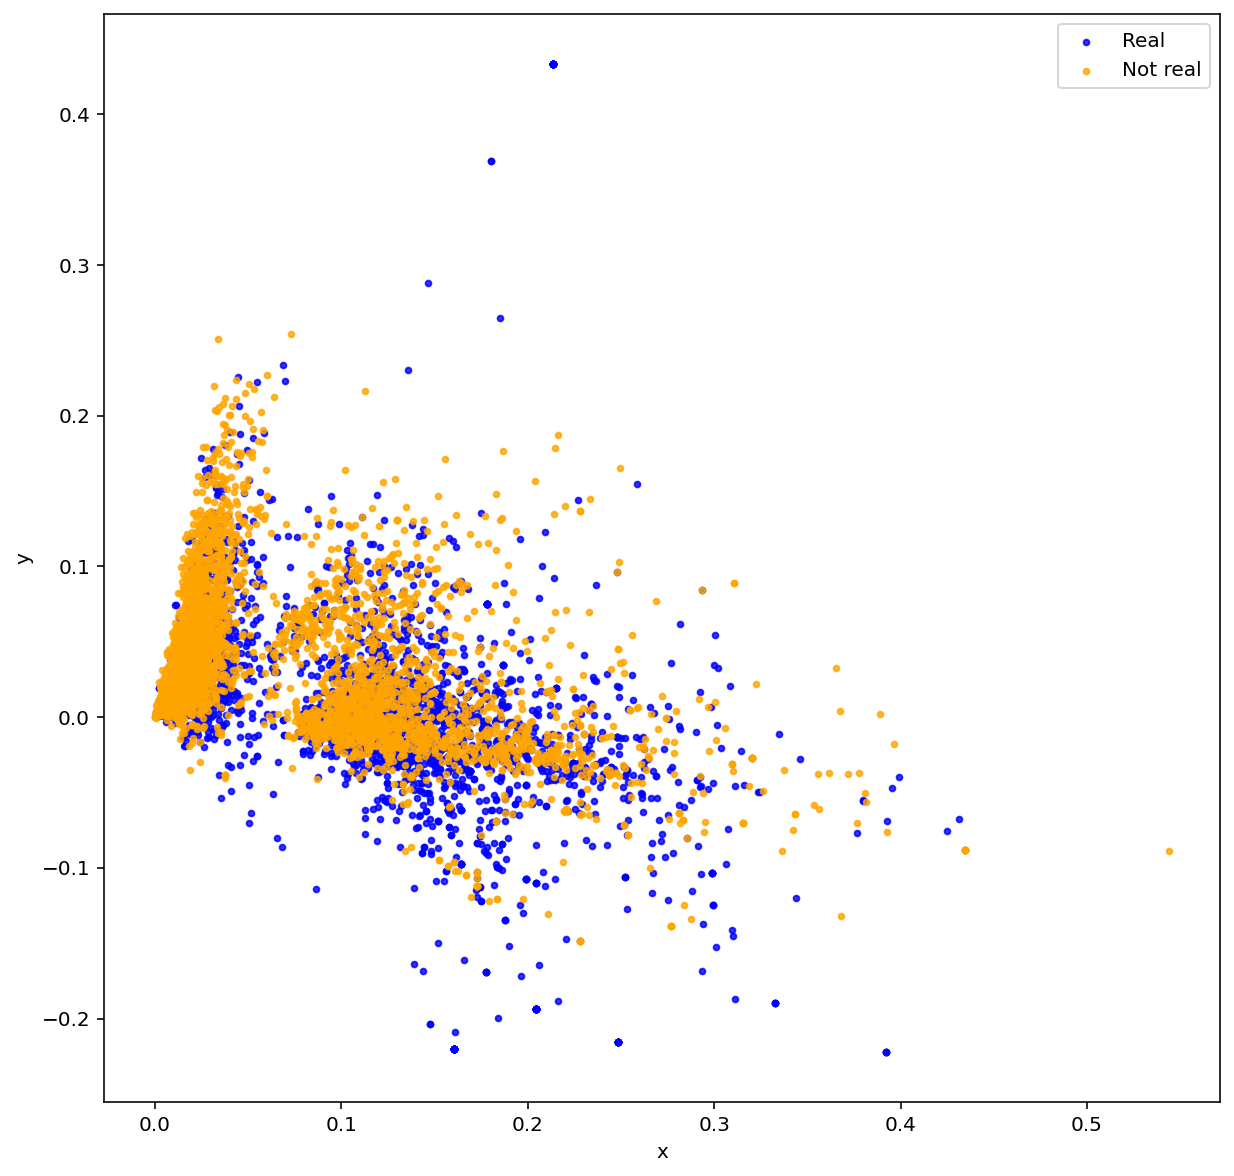

In [107]:
ax = to_plot[to_plot['target'] == 1].plot.scatter(x='x', y='y', s=8, alpha=0.8, color='blue', label='Real', figsize=(10, 10))
to_plot[to_plot['target'] == 0].plot.scatter(x='x', y='y', s=8, alpha=0.8, color='orange', label='Not real', ax=ax)

### TF-IDF matrix

In [108]:
x_train, x_test, y_train, y_test = \
train_test_split(tweets['text'], tweets.loc[:,['id','target']], test_size = 0.25, random_state = 123)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
train_vectors = tfidf_vectorizer.fit_transform(x_train)
test_vectors = tfidf_vectorizer.transform(x_test)
array = train_vectors.todense()

tfidf_matrix = pd.DataFrame(array)
tfidf_matrix.head(10)

,0,1,2,3,4,5,6,7,8,9,...,11190,11191,11192,11193,11194,11195,11196,11197,11198,11199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
y_train.reset_index(drop=True, inplace=True)
y_train.head()

,id,target
0,4774,1
1,6820,0
2,1069,0
3,474,0
4,8208,0


#### Basic Naive Bayes 

En el caso de una predicción binaria es recomendable bernoulli

In [110]:
from sklearn.naive_bayes import BernoulliNB

bernoulli = BernoulliNB().fit(train_vectors, y_train['target'])

In [111]:
from sklearn.metrics import accuracy_score
predicted = bernoulli.predict(test_vectors)
print(accuracy_score(y_test['target'], predicted))

0.8128025820333513


#### Tunning

In [112]:
tfidf_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,11190,11191,11192,11193,11194,11195,11196,11197,11198,11199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
features = tfidf_matrix.columns

In [114]:
alpha = np.linspace(0.5, 1.0, 20)
alpha = np.around(alpha, decimals=4)
alpha

array([0.5   , 0.5263, 0.5526, 0.5789, 0.6053, 0.6316, 0.6579, 0.6842,
       0.7105, 0.7368, 0.7632, 0.7895, 0.8158, 0.8421, 0.8684, 0.8947,
       0.9211, 0.9474, 0.9737, 1.    ])

In [115]:
grid = [{"alpha":alpha}]

In [116]:
from sklearn.model_selection import GridSearchCV

#classifier = BernoulliNB()
#gridsearch = GridSearchCV(classifier, grid, scoring = 'neg_log_loss', cv = 4)
#gridsearch.fit(df[features], y_train['target'])
#print("Best parameter: ",gridsearch.best_params_)

In [117]:
bernoulli_t = BernoulliNB(alpha=0.9474).fit(train_vectors, y_train['target'])
predicted_t = bernoulli_t.predict(test_vectors)
print(accuracy_score(y_test['target'], predicted_t))

0.8138784292630447


### LightGBM

* Count vectorization

In [118]:
from sklearn.metrics import classification_report

In [119]:
x_train, x_test, y_train, y_test = \
train_test_split(tweets[['text', 'keyword']], tweets['target'], test_size = 0.25, random_state = 123)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vectorizer = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english', max_features=5000)
train_vectors = tfidf_vectorizer.fit_transform(x_train['text'])
test_vectors = tfidf_vectorizer.transform(x_test['text'])

In [120]:
tfidf_vectorizer = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english', max_features=300)
key_train_vectors = tfidf_vectorizer.fit_transform(x_train['keyword'])
key_test_vectors = tfidf_vectorizer.transform(x_test['keyword'])

In [121]:
from scipy.sparse import hstack
matrix_final = hstack([train_vectors, key_train_vectors])

In [122]:
matrix_final = matrix_final.astype('float32')

In [123]:
import lightgbm as lgb
d_train = lgb.Dataset(matrix_final, label=y_train)

params = {
    'learning_rate' : 0.02,
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'num_leaves' : 50,
    'max_depth' : 5
}

gbm = lgb.train(params, d_train, 5000)

In [124]:
test_final = hstack([test_vectors, key_test_vectors])
test_final = test_final.astype('float32')
y_pred = gbm.predict(test_final)

for i in range (0, len(y_pred)):
    if y_pred[i] >= 0.5:       
        y_pred[i] = 1
    else:  
        y_pred[i] = 0

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.8025820333512641


/Users/matiascano/.pyenv/versions/3.7.7/lib/python3.7/site-packages/lightgbm/basic.py:546: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [125]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1055
           1       0.82      0.70      0.75       804

    accuracy                           0.80      1859
   macro avg       0.81      0.79      0.79      1859
weighted avg       0.80      0.80      0.80      1859



### Features

In [126]:
tweets_features = pd.read_csv("train_features.csv")
test_features = pd.read_csv("test_features.csv")
keyword_w2v = pd.read_csv("keyword_features.csv")

In [127]:
tweets_features.head(1)

,id,text,target,text_without_stopwords,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords,stopword_word_ratio,adjectives_count,nouns_count,verbs_count,adverbs_count
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason May ALLAH Forgive us,69,4.384615,13,13,0.2732,6,1,0,1,7,0.461538,0,6,1,0


In [128]:
test_features.head(1)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash


In [129]:
tweets_features = tweets_features.drop(columns=['text', 'text_without_stopwords', 'target'])

In [130]:
tweets_features.head(1)

,id,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords,stopword_word_ratio,adjectives_count,nouns_count,verbs_count,adverbs_count
0,1,69,4.384615,13,13,0.2732,6,1,0,1,7,0.461538,0,6,1,0


#### Merge all features

In [131]:
tweets.head(1)

,id,keyword,location,text,target
0,1,NULL,NaN,deed reason earthquak may allah forgiv us,1


In [132]:
keyword_w2v.head(1)

,keyword,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,NaN,-0.002684,-0.001899,-0.000798,-0.001893,0.003133,0.002236,-0.001299,-0.003281,-0.004414,...,-0.002605,-0.004927,0.001684,0.004702,-0.00416,0.003781,-0.003558,0.003921,0.000945,-0.002725


In [133]:
tweets_features.head(1)

,id,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords,stopword_word_ratio,adjectives_count,nouns_count,verbs_count,adverbs_count
0,1,69,4.384615,13,13,0.2732,6,1,0,1,7,0.461538,0,6,1,0


In [134]:
merged = tweets.merge(tweets_features, left_on='id', right_on='id')

In [135]:
total_features = merged.merge(keyword_w2v, left_on='keyword', right_on='keyword')

In [136]:
total_features.head()

,id,keyword,location,text,target,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,48,ablaze,Birmingham,bbcmtd wholesal market ablaz http co,1,55,10.200000,5,5,0.0000,...,0.002117,0.003154,0.00422,0.004947,-0.000484,0.003842,0.003322,0.002055,0.003155,0.002922
1,49,ablaze,Est. September 2012 - Bristol,alway tri bring heavi metal rt http co,0,67,5.800000,10,10,0.0000,...,0.002117,0.003154,0.00422,0.004947,-0.000484,0.003842,0.003322,0.002055,0.003155,0.002922
2,50,ablaze,AFRICA,africanbaz break news nigeria flag set ablaz a...,1,82,8.222222,9,9,0.0000,...,0.002117,0.003154,0.00422,0.004947,-0.000484,0.003842,0.003322,0.002055,0.003155,0.002922
3,52,ablaze,"Philadelphia, PA",cri set ablaz,0,34,4.000000,7,7,-0.5255,...,0.002117,0.003154,0.00422,0.004947,-0.000484,0.003842,0.003322,0.002055,0.003155,0.002922
4,53,ablaze,"London, UK",plus side look sky last night ablaz http co,0,76,4.923077,13,13,0.0000,...,0.002117,0.003154,0.00422,0.004947,-0.000484,0.003842,0.003322,0.002055,0.003155,0.002922


In [137]:
features = total_features.columns
features = features.drop('target')

#### Features with tweet vectorizer

In [138]:
x_train, x_test, y_train, y_test = \
train_test_split(total_features[features], total_features['target'], test_size = 0.25, random_state = 123)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vectorizer = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english', max_features=11000)
train_vectors = tfidf_vectorizer.fit_transform(x_train['text'])
test_vectors = tfidf_vectorizer.transform(x_test['text'])

In [139]:
train_array = train_vectors.todense()
train_matrix = pd.DataFrame(train_array)
x_train.reset_index(inplace=True, drop=True)
train_matrix['id'] = x_train['id']
X_train = x_train.merge(train_matrix).drop(columns=['keyword', 'location', 'text', 'id'])

In [140]:
test_array = test_vectors.todense()
test_matrix = pd.DataFrame(test_array)
x_test.reset_index(inplace=True, drop=True)
test_matrix['id'] = x_test['id']
X_test = x_test.merge(test_matrix).drop(columns=['keyword', 'location', 'text', 'id'])

In [141]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, y_train)

params : {
    'learning_rate' : 0.02,
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'num_leaves' : 500,
    'max_depth' : 2,
    'max_bin': 1000
}

gbm = lgb.train(params, d_train, 10000)

In [142]:
y_pred = gbm.predict(X_test)

for i in range (0, len(y_pred)):
    if y_pred[i] > 0.5:       
        y_pred[i] = 1
    else:  
        y_pred[i] = 0

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.7766937669376693


In [143]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1070
           1       0.75      0.70      0.72       775

    accuracy                           0.78      1845
   macro avg       0.77      0.77      0.77      1845
weighted avg       0.78      0.78      0.78      1845



In [152]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [153]:
model = lgb.LGBMClassifier()

param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5, scoring_fit='accuracy')

print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 34.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 67.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 89.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 112.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 137.6min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 166.0min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 198.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 270.3min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 822.1min
[Parallel(n_jobs=-1)]: Done 9097 tasks   

0.7782410470277096
{'colsample_bytree': 0.7, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 400, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 1.3, 'subsample': 0.8, 'subsample_freq': 20}


-------

#### Character process

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
text = pd.read_csv("train.csv", usecols=['text', 'target'])
test_text = pd.read_csv("test.csv", usecols=['text'])

In [4]:
text.drop_duplicates(subset = 'text', keep = False, inplace = True)
text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7434 non-null   object
 1   target  7434 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 174.2+ KB


In [5]:
text['text'] = text['text'].apply(lambda x: x.lower())
test_text['text'] = test_text['text'].apply(lambda x: x.lower())

In [6]:
text.head()

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1


In [7]:
test_text.head()

,text
0,just happened a terrible car crash
1,"heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,apocalypse lighting. #spokane #wildfires
4,typhoon soudelor kills 28 in china and taiwan


In [8]:
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(text['text'])

In [9]:
# Caracteres muy horrendos
tk.word_index

{'UNK': 1,
 ' ': 2,
 'e': 3,
 't': 4,
 'a': 5,
 'o': 6,
 'i': 7,
 'n': 8,
 's': 9,
 'r': 10,
 'h': 11,
 'l': 12,
 'c': 13,
 'd': 14,
 'u': 15,
 'p': 16,
 'm': 17,
 '/': 18,
 'g': 19,
 'f': 20,
 'y': 21,
 'w': 22,
 '.': 23,
 'b': 24,
 'k': 25,
 'v': 26,
 ':': 27,
 '#': 28,
 'j': 29,
 "'": 30,
 '?': 31,
 'x': 32,
 '@': 33,
 'z': 34,
 '0': 35,
 '1': 36,
 'q': 37,
 '-': 38,
 '2': 39,
 '5': 40,
 '3': 41,
 '4': 42,
 '7': 43,
 '9': 44,
 '6': 45,
 '!': 46,
 '8': 47,
 '\n': 48,
 '_': 49,
 '\x89': 50,
 'û': 51,
 ';': 52,
 '&': 53,
 ')': 54,
 '(': 55,
 '*': 56,
 'ª': 57,
 '|': 58,
 '[': 59,
 ']': 60,
 'å': 61,
 '+': 62,
 'ï': 63,
 'ê': 64,
 '=': 65,
 '÷': 66,
 '%': 67,
 'ò': 68,
 '$': 69,
 '\x9d': 70,
 '~': 71,
 'ó': 72,
 'ì': 73,
 '©': 74,
 '¢': 75,
 '£': 76,
 '^': 77,
 '¨': 78,
 'è': 79,
 '\\': 80,
 '¼': 81,
 '}': 82,
 'ñ': 83,
 '¤': 84,
 '¡': 85,
 '`': 86,
 '{': 87,
 ',': 88,
 'ã': 89,
 'ü': 90,
 'ç': 91,
 'â': 92,
 '«': 93,
 '>': 94,
 '´': 95,
 '¬': 96}

In [10]:
alphabet="abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1
    
tk.word_index = char_dict.copy() 
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1 #UNK es el valor mas alto

In [11]:
tk.word_index

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '0': 27,
 '1': 28,
 '2': 29,
 '3': 30,
 '4': 31,
 '5': 32,
 '6': 33,
 '7': 34,
 '8': 35,
 '9': 36,
 ',': 37,
 ';': 38,
 '.': 39,
 '!': 40,
 '?': 41,
 ':': 42,
 "'": 43,
 '"': 44,
 '/': 45,
 '\\': 46,
 '|': 47,
 '_': 48,
 '@': 49,
 '#': 50,
 '$': 51,
 '%': 52,
 '^': 53,
 '&': 54,
 '*': 55,
 '~': 56,
 '`': 57,
 '+': 58,
 '-': 59,
 '=': 60,
 '<': 61,
 '>': 62,
 '(': 63,
 ')': 64,
 '[': 65,
 ']': 66,
 '{': 67,
 '}': 68,
 'UNK': 69}

In [12]:
# Ahora el texto se representa con una secuencia de caracteres
sequences = tk.texts_to_sequences(text['text'])
test_sequences = tk.texts_to_sequences(test_text['text'])

In [13]:
sequences[0]

[15,
 21,
 18,
 69,
 4,
 5,
 5,
 4,
 19,
 69,
 1,
 18,
 5,
 69,
 20,
 8,
 5,
 69,
 18,
 5,
 1,
 19,
 15,
 14,
 69,
 15,
 6,
 69,
 20,
 8,
 9,
 19,
 69,
 50,
 5,
 1,
 18,
 20,
 8,
 17,
 21,
 1,
 11,
 5,
 69,
 13,
 1,
 25,
 69,
 1,
 12,
 12,
 1,
 8,
 69,
 6,
 15,
 18,
 7,
 9,
 22,
 5,
 69,
 21,
 19,
 69,
 1,
 12,
 12]

In [14]:
test_sequences[0]

[10,
 21,
 19,
 20,
 69,
 8,
 1,
 16,
 16,
 5,
 14,
 5,
 4,
 69,
 1,
 69,
 20,
 5,
 18,
 18,
 9,
 2,
 12,
 5,
 69,
 3,
 1,
 18,
 69,
 3,
 18,
 1,
 19,
 8]

In [15]:
# Padding de cada secuencia para que todas tengan el mismo largo
data = pad_sequences(sequences, maxlen=1014, padding='post')
test_data = pad_sequences(test_sequences, maxlen=1014, padding='post')

In [16]:
data = np.array(data)
data.shape

(7434, 1014)

In [20]:
test_data = np.array(test_data)
test_data.shape

(3263, 1014)

In [21]:
train_classes = text['target'].values

In [22]:
train_classes[:30]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

#### CHAR CNN

In [23]:
size = len(tk.word_index)
size

69

In [24]:
embedding_weights = []
embedding_weights.append(np.zeros(size))

for char, i in tk.word_index.items():
    row = np.zeros(size)
    row[i-1] = 1
    embedding_weights.append(row)
    
embedding_weights = np.array(embedding_weights)

In [25]:
print(embedding_weights.shape)

(70, 69)


In [26]:
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model

In [27]:
# Parametros
input_size = 1014
embedding_size = 69
conv_layers = [[256, 7, 2], 
               [256, 7, 2], 
               [256, 2, -1], 
               [256, 2, -1], 
               [256, 2, -1], 
               [256, 2, 1]]

fully_connected_layers = [1024, 1024]
num_of_classes = 1
dropout_p = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'

embedding_layer = Embedding(size+1, 
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')

# Embedding 
x = embedding_layer(inputs)

# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x) 
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)
        
x = Flatten()(x)

# Fully connected layers 
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(dropout_p)(x)
    
# Output Layer
predictions = Dense(num_of_classes, activation='sigmoid')(x)

# Build model
model1 = Model(inputs=inputs, outputs=predictions)
model1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1014)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1014, 69)          4830      
_________________________________________________________________
conv1d (Conv1D)              (None, 1008, 256)         123904    
_________________________________________________________________
activation (Activation)      (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 504, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 256)          459008    
_________________________________________________________________
activation_1 (Activation)    (None, 498, 256)          0     

In [28]:
x_train, x_test, y_train, y_test = \
train_test_split(data, train_classes, test_size = 0.25, random_state = 123)

from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', patience = 2, verbose=1)
callbacks = [callback]

model1.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=128,
          epochs=6,
          verbose=2,
          callbacks=callback)

Epoch 1/6
44/44 - 136s - loss: 0.6944 - accuracy: 0.5726 - val_loss: 0.6785 - val_accuracy: 0.5675
Epoch 2/6
44/44 - 141s - loss: 0.6528 - accuracy: 0.6151 - val_loss: 0.6365 - val_accuracy: 0.6541
Epoch 3/6
44/44 - 136s - loss: 0.6396 - accuracy: 0.6326 - val_loss: 0.6213 - val_accuracy: 0.6595
Epoch 4/6
44/44 - 144s - loss: 0.6093 - accuracy: 0.6691 - val_loss: 0.5821 - val_accuracy: 0.7052
Epoch 5/6
44/44 - 143s - loss: 0.5665 - accuracy: 0.7175 - val_loss: 0.5326 - val_accuracy: 0.7214
Epoch 6/6
44/44 - 142s - loss: 0.4324 - accuracy: 0.8131 - val_loss: 0.5312 - val_accuracy: 0.7633


In [ ]:
y_submit = model1.predict(submit_data)

y_submit

s = []

for l in y_submit:
    if l[0] > l[1]:
        s.append(0)
    else:
        s.append(1)

s

test_text = pd.read_csv("test.csv", usecols=['id'])

test_text['target'] = s

test_text

test_text.to_csv('submit_prueba_35.csv', index=False)

In [31]:
# Parametros
input_size = 1014
embedding_size = 69
conv_layers = [[256, 7, 1], 
               [256, 7, 1], 
               [256, 1, -1], 
               [256, 1, -1], 
               [256, 1, -1], 
               [256, 1, 1]]

fully_connected_layers = [1024, 1024]
num_of_classes = 1
dropout_p = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'

embedding_layer = Embedding(size+1, 
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')

# Embedding 
x = embedding_layer(inputs)

# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x) 
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)
        
x = Flatten()(x)

# Fully connected layers 
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(dropout_p)(x)
    
# Output Layer
predictions = Dense(num_of_classes, activation='sigmoid')(x)

# Build model
model2 = Model(inputs=inputs, outputs=predictions)
model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1014)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1014, 69)          4830      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1008, 256)         123904    
_________________________________________________________________
activation_12 (Activation)   (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1008, 256)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1002, 256)         459008    
_________________________________________________________________
activation_13 (Activation)   (None, 1002, 256)         0   

In [33]:
x_train, x_test, y_train, y_test = \
train_test_split(data, train_classes, test_size = 0.25, random_state = 123)

from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', patience = 1, verbose=1)
callbacks = [callback]

model2.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=128,
          epochs=10,
          verbose=2,
          callbacks=callback)

Epoch 1/10
44/44 - 321s - loss: 0.6758 - accuracy: 0.5670 - val_loss: 0.6429 - val_accuracy: 0.6498
Epoch 2/10
44/44 - 302s - loss: 0.6466 - accuracy: 0.6326 - val_loss: 0.6286 - val_accuracy: 0.6692
Epoch 3/10
44/44 - 331s - loss: 0.6313 - accuracy: 0.6511 - val_loss: 0.6183 - val_accuracy: 0.6638
Epoch 4/10
44/44 - 335s - loss: 0.6213 - accuracy: 0.6604 - val_loss: 0.6086 - val_accuracy: 0.6525
Epoch 5/10
44/44 - 309s - loss: 0.5739 - accuracy: 0.7031 - val_loss: 0.5543 - val_accuracy: 0.7257
Epoch 6/10
44/44 - 298s - loss: 0.4835 - accuracy: 0.7742 - val_loss: 0.5292 - val_accuracy: 0.7552
Epoch 7/10
44/44 - 298s - loss: 0.3713 - accuracy: 0.8377 - val_loss: 0.5945 - val_accuracy: 0.7171
Epoch 00007: early stopping


In [40]:
# Parametros
input_size = 1014
embedding_size = 69
conv_layers = [[256, 7, 2], 
               [256, 2, -1], 
               [256, 2, 1]]

fully_connected_layers = [1024, 1024]
num_of_classes = 1
dropout_p = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'

embedding_layer = Embedding(size+1, 
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')

# Embedding 
x = embedding_layer(inputs)

# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x) 
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)
        
x = Flatten()(x)

# Fully connected layers 
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(dropout_p)(x)
    
# Output Layer
predictions = Dense(num_of_classes, activation='sigmoid')(x)

# Build model
model3 = Model(inputs=inputs, outputs=predictions)
model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model3.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1014)]            0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 1014, 69)          4830      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 1008, 256)         123904    
_________________________________________________________________
activation_33 (Activation)   (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 504, 256)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 503, 256)          131328    
_________________________________________________________________
activation_34 (Activation)   (None, 503, 256)          0   

In [41]:
x_train, x_test, y_train, y_test = \
train_test_split(data, train_classes, test_size = 0.25, random_state = 123)

from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', patience = 1, verbose=1)
callbacks = [callback]

model3.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=128,
          epochs=10,
          verbose=2,
          callbacks=callback)

Epoch 1/10
44/44 - 111s - loss: 0.6784 - accuracy: 0.5693 - val_loss: 0.6300 - val_accuracy: 0.6547
Epoch 2/10
44/44 - 111s - loss: 0.6295 - accuracy: 0.6407 - val_loss: 0.5961 - val_accuracy: 0.7068
Epoch 3/10
44/44 - 111s - loss: 0.5746 - accuracy: 0.7116 - val_loss: 0.5644 - val_accuracy: 0.7041
Epoch 4/10
44/44 - 120s - loss: 0.4727 - accuracy: 0.7891 - val_loss: 0.5383 - val_accuracy: 0.7477
Epoch 5/10
44/44 - 116s - loss: 0.3397 - accuracy: 0.8560 - val_loss: 0.5699 - val_accuracy: 0.7472
Epoch 00005: early stopping


In [87]:
# Parametros
input_size = 1014
embedding_size = 69

fully_connected_layers = [1024, 1024]
num_of_classes = 1
dropout_p = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'

embedding_layer = Embedding(size+1, 
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')

# Embedding 
x = embedding_layer(inputs)

# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x) 
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)
        
x = Flatten()(x)
x = Dense(dense_size, activation='relu')(x)
predictions = Dense(num_of_classes, activation='sigmoid')(x)

# Build model
model3 = Model(inputs=inputs, outputs=predictions)
model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model3.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1014)]            0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 1014, 69)          4830      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 1008, 256)         123904    
_________________________________________________________________
activation_39 (Activation)   (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 50, 256)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 49, 256)           131328    
_________________________________________________________________
activation_40 (Activation)   (None, 49, 256)           0  

In [43]:
x_train, x_test, y_train, y_test = \
train_test_split(data, train_classes, test_size = 0.25, random_state = 123)

from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', patience = 1, verbose=1)
callbacks = [callback]

model3.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=128,
          epochs=10,
          verbose=2,
          callbacks=callback)

Epoch 1/10
44/44 - 114s - loss: 0.6943 - accuracy: 0.5700 - val_loss: 0.6311 - val_accuracy: 0.6428
Epoch 2/10
44/44 - 119s - loss: 0.6380 - accuracy: 0.6355 - val_loss: 0.6184 - val_accuracy: 0.6573
Epoch 3/10
44/44 - 127s - loss: 0.6180 - accuracy: 0.6603 - val_loss: 0.5965 - val_accuracy: 0.6885
Epoch 4/10
44/44 - 126s - loss: 0.5794 - accuracy: 0.7049 - val_loss: 0.5827 - val_accuracy: 0.7020
Epoch 5/10
44/44 - 128s - loss: 0.5218 - accuracy: 0.7408 - val_loss: 0.5590 - val_accuracy: 0.7171
Epoch 6/10
44/44 - 121s - loss: 0.4453 - accuracy: 0.8007 - val_loss: 0.5497 - val_accuracy: 0.7402
Epoch 7/10
44/44 - 139s - loss: 0.3150 - accuracy: 0.8667 - val_loss: 0.6257 - val_accuracy: 0.7396
Epoch 00007: early stopping


### Text clasf con TensorFlow Hub

In [50]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

In [49]:
x_train, x_test, y_train, y_test = \
train_test_split(text['text'], text['target'], test_size = 0.25, random_state = 123)

In [76]:
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(x_train[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 0.37495357,  0.04884983, -0.44728252,  0.19069983,  0.22855435,
        -1.601063  , -0.578384  ,  1.0811323 , -0.7617105 ,  1.033736  ,
        -0.46894896,  1.1409842 , -0.22123253, -0.29332948, -0.75760084,
         1.2982581 , -0.25766143, -0.7316822 , -0.39457026,  0.04495662],
       [ 1.6863625 , -0.843238  ,  1.594401  ,  1.4065715 , -2.1663356 ,
        -2.7666457 , -2.5575192 ,  1.3733628 ,  2.1256437 , -0.55860907,
        -2.062001  ,  1.8521987 ,  1.5375882 ,  0.0337178 , -2.3348963 ,
         2.1301465 ,  0.6694136 , -0.08186518, -2.0231245 , -1.269589  ],
       [ 0.9888268 , -0.08674138,  0.74446404,  1.2706661 ,  0.6064783 ,
        -1.0720532 , -1.1698616 ,  1.4409689 ,  1.2004998 , -0.42373168,
        -1.0143037 ,  1.0753728 ,  0.7560935 ,  0.1987023 , -1.0678316 ,
         0.60962903,  0.5624571 , -0.7523041 , -0.775114  , -0.9879701 ]],
      dtype=float32)>

In [84]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20],
                           input_shape=[], dtype=tf.string)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_41 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 17        
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


In [85]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', patience = 1, verbose=1)
callbacks = [callback]

history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/40
11/11 [==============================] - 0s 16ms/step - loss: 0.7068 - accuracy: 0.6407 - val_loss: 0.6957 - val_accuracy: 0.6342
Epoch 2/40
11/11 [==============================] - 0s 9ms/step - loss: 0.6959 - accuracy: 0.6475 - val_loss: 0.6867 - val_accuracy: 0.6487
Epoch 3/40
11/11 [==============================] - 0s 9ms/step - loss: 0.6882 - accuracy: 0.6513 - val_loss: 0.6797 - val_accuracy: 0.6568
Epoch 4/40
11/11 [==============================] - 0s 9ms/step - loss: 0.6822 - accuracy: 0.6603 - val_loss: 0.6741 - val_accuracy: 0.6713
Epoch 5/40
11/11 [==============================] - 0s 8ms/step - loss: 0.6774 - accuracy: 0.6714 - val_loss: 0.6693 - val_accuracy: 0.6826
Epoch 6/40
11/11 [==============================] - 0s 8ms/step - loss: 0.6732 - accuracy: 0.6827 - val_loss: 0.6651 - val_accuracy: 0.6998
Epoch 7/40
11/11 [==============================] - 0s 8ms/step - loss: 0.6696 - accuracy: 0.6988 - val_loss: 0.6613 - val_accuracy: 0.7058
Epoch 8/40
11/11 [=